In [1]:
!pip install tensorboard
!pip install adversarial-robustness-toolbox

from keras.models import load_model
from art.utils import load_dataset
from art.classifiers import KerasClassifier
from art.attacks.fast_gradient import FastGradientMethod
from art.attacks.newtonfool import NewtonFool
from art.attacks.iterative_method import BasicIterativeMethod
from art.defences.adversarial_trainer import AdversarialTrainer

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import RMSprop
import numpy as np
from matplotlib import pyplot as plt

import warnings
from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

import random as rn


warnings.resetwarnings()  # Maybe somebody else is messing with the warnings system?
warnings.filterwarnings('ignore')  # Ignore everything
import keras
print("Keras version  :",keras.__version__)

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.


Using TensorFlow backend.


Keras version  : 2.1.4


In [2]:
# Define a few utility functions

def setupSubPlots(numCols,maxRows):
    numRows=1+(maxRows-1)//numCols
    return plt.subplots(numRows,numCols,squeeze=False,figsize=(20,numRows/3*4))

def plotImage(img,axs,ix,numCols,title=None):
    ax=axs[ix//numCols][ix%numCols]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if title: 
        ax.set_title(title)
        ax.set_xticks([])
    return ax.imshow(img.squeeze())

def showImages(imgTable, limit, numCols=15):
    ''' Image plotting function, using a set number of columns
    '''
    limit=min(limit,len(imgTable))
    if limit<numCols: numCols=limit
    fig, axs = setupSubPlots(numCols,limit)
    for ix,img in enumerate(imgTable):
        if ix>=limit: break
        plotImage(img,axs,ix,numCols)
    return

def showImagesAccuracy(description,images, labels, predictList, maxShown=30, numCols=15):
    ''' Check Images prediction accuracy, count and display mismatches
    '''
    idx = 0
    errorsCount = 0
    shown = 0
    fig, axs = setupSubPlots(numCols,maxShown)
    for idx,img in enumerate(images):
        predicted = np.argmax(predictList[idx])
        actual = np.argmax(labels[idx])
        if predicted != actual:
            errorsCount += 1
            if shown < maxShown:
                # Plotting first samples of MNIST
                plotImage(img,axs,shown,numCols,"{}->{}".format(actual,predicted))
                shown += 1
    # Compute accuracy as a percentage         
    accuracy = (100-(errorsCount/len(images))*100)
    print("{} classifier succcess rate: {:.2f}%".format(description,accuracy))
    return accuracy

def get_file1(filename, url, path=None, extract=False):
    """
    Downloads a file from a URL if it not already in the cache. The file at indicated by `url` is downloaded to the
    path `path` (default is ~/.art/data). and given the name `filename`. Files in tar, tar.gz, tar.bz, and zip formats
    can also be extracted. This is a simplified version of the function with the same name in Keras.

    :param filename: Name of the file.
    :type filename: `str`
    :param url: Download URL.
    :type url: `str`
    :param path: Folder to store the download. If not specified, `~/.art/data` is used instead.
    :type: `str`
    :param extract: If true, tries to extract the archive.
    :type extract: `bool`
    :return: Path to the downloaded file.
    :rtype: `str`
    """
    if path is None:
        from art import DATA_PATH
        path_ = os.path.expanduser(DATA_PATH)
    else:
        path_ = os.path.expanduser(path)
    if not os.access(path_, os.W_OK):
        path_ = os.path.join('./', '.art')
    if not os.path.exists(path_):
        os.makedirs(path_)

    if extract:
        extract_path = os.path.join(path_, filename)
        full_path = extract_path + '.tar.gz'
    else:
        full_path = os.path.join(path_, filename)

    # Determine if dataset needs downloading
    download = not os.path.exists(full_path)

    if download:
        # logger.info('Downloading data from %s', url)
        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                from six.moves.urllib.error import HTTPError, URLError
                from six.moves.urllib.request import urlretrieve

                urlretrieve(url, full_path)
            except HTTPError as e:
                raise Exception(error_msg.format(url, e.code, e.msg))
            except URLError as e:
                raise Exception(error_msg.format(url, e.errno, e.reason))
        except (Exception, KeyboardInterrupt):
            if os.path.exists(full_path):
                os.remove(full_path)
            raise

    if extract:
        if not os.path.exists(extract_path):
            _extract(full_path, path_)
        return extract_path

    return full_path


def preprocess(x, y, nb_classes=10, max_value=255):
    """Scales `x` to [0, 1] and converts `y` to class categorical confidences.

    :param x: Data instances
    :type x: `np.ndarray`
    :param y: Labels
    :type y: `np.ndarray`
    :param nb_classes: Number of classes in dataset
    :type nb_classes: `int`
    :param max_value: Original maximum allowed value for features
    :type max_value: `int`
    :return: rescaled values of `x`, `y`
    :rtype: `tuple`
    """
    x = x.astype('float32') / max_value
    y = to_categorical(y, nb_classes)

    return x, y

def to_categorical(labels, nb_classes=None):
    """
    Convert an array of labels to binary class matrix.

    :param labels: An array of integer labels of shape `(nb_samples,)`
    :type labels: `np.ndarray`
    :param nb_classes: The number of classes (possible labels)
    :type nb_classes: `int`
    :return: A binary matrix representation of `y` in the shape `(nb_samples, nb_classes)`
    :rtype: `np.ndarray`
    """
    labels = np.array(labels, dtype=np.int32)
    if not nb_classes:
        nb_classes = np.max(labels) + 1
    categorical = np.zeros((labels.shape[0], nb_classes), dtype=np.float32)
    categorical[np.arange(labels.shape[0]), np.squeeze(labels)] = 1
    return categorical

def load_mnist_data(raw=False):
    """Loads MNIST dataset from `DATA_PATH` or downloads it if necessary.

    :param raw: `True` if no preprocessing should be applied to the data. Otherwise, data is normalized to 1.
    :type raw: `bool`
    :return: `(x_train, y_train), (x_test, y_test), min, max`
    :rtype: `(np.ndarray, np.ndarray), (np.ndarray, np.ndarray), float, float`
    """
    # from art import DATA_PATH

    path = get_file1('mnist.npz', url='https://s3.amazonaws.com/img-datasets/mnist.npz')

    f = np.load(path)
    x_train = f['x_train']
    y_train = f['y_train']
    x_test = f['x_test']
    y_test = f['y_test']
    f.close()

    # Add channel axis
    min_, max_ = 0, 255
    if not raw:
        min_, max_ = 0., 1.
        x_train = np.expand_dims(x_train, axis=3)
        x_test = np.expand_dims(x_test, axis=3)
        x_train, y_train = preprocess(x_train, y_train)
        x_test, y_test = preprocess(x_test, y_test)

    return (x_train, y_train), (x_test, y_test), min_, max_


In [3]:
import os

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()


In [4]:
# from keras.datasets import mnist
# # Load pre-shuffled MNIST data into train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# Read MNIST dataset
# (x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str('mnist'))
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist_data()

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details : https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# k.set_session(sess)

# CREATE the CNN for our HandWritten Digits recognition
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               692352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Train the Classifier wrapper

Original_Classifier = KerasClassifier(model,use_logits=False)
#Original_Classifier = KerasClassifier((0,1),model,use_logits=False)
#Original_Classifier = model

Original_Classifier.fit(x_train, y_train, batch_size=128, nb_epochs=3)

Epoch 1/3
469/468 [==============================] - 86s 182ms/step - loss: 0.2603 - acc: 0.9226
Epoch 2/3
469/468 [==============================] - 81s 173ms/step - loss: 0.0788 - acc: 0.9771
Epoch 3/3
469/468 [==============================] - 85s 181ms/step - loss: 0.0516 - acc: 0.9845


Original images with Original  classifier succcess rate: 98.41%


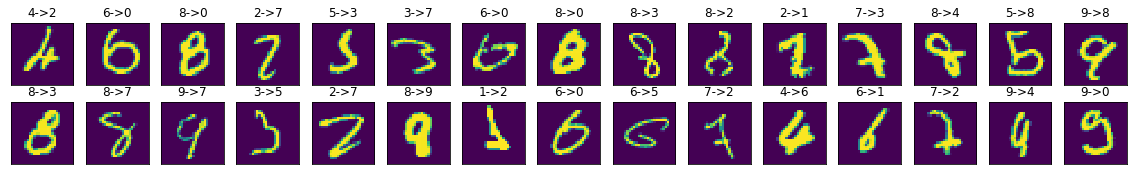

In [6]:
# Test the classifier against fresh test data
predictions = Original_Classifier.predict(x_test)
# count false predictions and display 30 first mismatches
OriginalAccOnTest = showImagesAccuracy('Original images with Original ',x_test, y_test, predictions, 30)

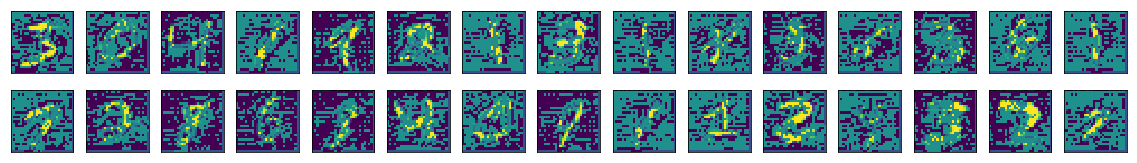

In [7]:
# Create modified train sub dataset (100 first images) with noise on it.
# Craft adversarial samples with the FastGradient Method
adv_crafter_FGM = FastGradientMethod(Original_Classifier, eps=0.5)

# generate one tenth of images for training set and full for test set
x_train_adv_FGM = adv_crafter_FGM.generate(x_train[:(len(x_train)//10)])
x_test_adv_FGM = adv_crafter_FGM.generate(x_test[:len(x_test)])
showImages(x_train_adv_FGM,30,15)

In [8]:
# Challenge the Classifier with FastGradient modified dataset
predictions = Original_Classifier.predict(x_test_adv_FGM[:len(x_test_adv_FGM)])
AccFGMOri=showImagesAccuracy('Adversarial FastGradient Images with Original ',x_test_adv_FGM, y_test, predictions, 0,15)

Adversarial FastGradient Images with Original  classifier succcess rate: 0.56%


In [9]:
# Data augmentation: expand the training set with the adversarial samples
x_train_robust = np.append(x_train, x_train_adv_FGM, axis=0)
y_train_robust = np.append(y_train, y_train[:len(x_train_adv_FGM)], axis=0)

x_test_robust = np.append(x_test, x_test_adv_FGM[:len(x_test_adv_FGM)], axis=0)
y_test_robust = np.append(y_test, y_test[:len(x_test_adv_FGM)], axis=0)

# Create a new Classifier trained using this extended dataset
Robust_Classifier = KerasClassifier(model,use_logits=False)
Robust_Classifier.fit(x_train_robust, y_train_robust, nb_epochs=3, batch_size=128)

Epoch 1/3
516/515 [==============================] - 92s 178ms/step - loss: 0.1677 - acc: 0.9552
Epoch 2/3
516/515 [==============================] - 94s 182ms/step - loss: 0.0562 - acc: 0.9830
Epoch 3/3
516/515 [==============================] - 91s 175ms/step - loss: 0.0400 - acc: 0.9884


Adversarial FastGradient Images with Robust classifier succcess rate: 98.22%


98.22

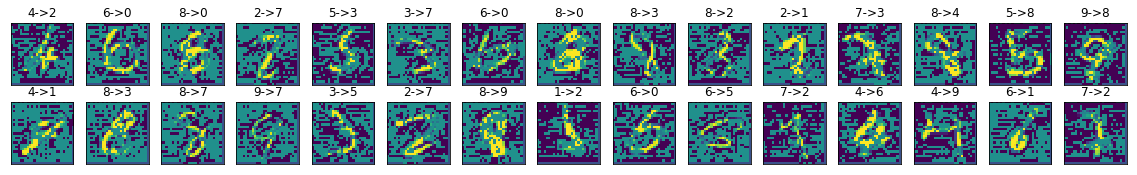

In [10]:
# Challenge the Robust Classifier with FastGradient modified dataset
predictions = Robust_Classifier.predict(x_test_adv_FGM[:len(x_test_adv_FGM)])
showImagesAccuracy('Adversarial FastGradient Images with Robust',x_test_adv_FGM, y_test, predictions, 30)

Original Images with Robust Classifier classifier succcess rate: 98.70%


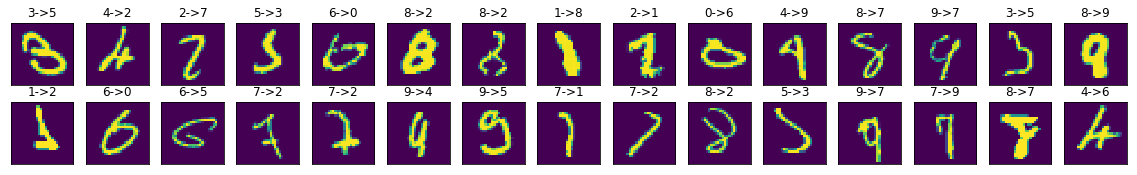

In [11]:
predictions = Robust_Classifier.predict(x_test)
# count false predictions and display 30 first mismatches
RobustAccOnTest = showImagesAccuracy('Original Images with Robust Classifier',x_test, y_test, predictions, 30)

In [12]:
print("Robust Classifier : %.2f%% vs Original Classifier : %.2f%%" % (RobustAccOnTest,OriginalAccOnTest))

Robust Classifier : 98.70% vs Original Classifier : 98.41%


In [13]:
# lattacks = BasicIterativeMethod(Original_Classifier,eps=0.3,eps_step=0.01, max_iter=40)

In [14]:
# ltrainer = AdversarialTrainer(Original_Classifier,attacks,ratio=1.0)
# ltrainer.fit(x_train,y_train, nb_epochs=10,batch_size=128)

# look at this sample notebook for more details on retraining your model leveraging ART lisdted attacks
# https://github.com/IBM/adversarial-robustness-toolbox/blob/master/notebooks/adversarial-training-mnist.ipynb